In [436]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [416]:
df = pd.read_csv('./travistorrent_8_2_2017.csv')

In [417]:
# selecting the required columns from dataset
df = df[['gh_pushed_at', 'gh_first_commit_created_at', 'tr_status', 'git_diff_src_churn', 'git_diff_test_churn', 'gh_sloc', 'gh_lang', 'gh_team_size', 'tr_build_id', 'tr_log_num_tests_run', 'tr_log_num_tests_ok', 'tr_log_num_tests_failed', 'gh_test_lines_per_kloc', 'gh_project_name', 'gh_test_cases_per_kloc']]

In [ ]:
if not os.path.exists('figs'):
    os.makedirs('figs')

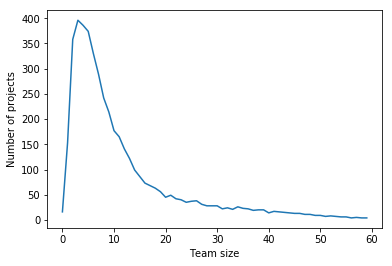

In [434]:
# Draw projects vs team size plot
projects = df.groupby(['gh_team_size']).gh_project_name.nunique()
plt.plot(projects)
plt.xlabel('Team size')
plt.ylabel('Number of projects')
plt.savefig('./figs/projects.eps', format='eps')

In [ ]:
df.shape

### Removing teams with size greater than 60, missing values. Creating needed features.

In [418]:
# removing projects with team size higher than 60 as there are only one sample project per team size
df = df.loc[df['gh_team_size'] < 60]

# Convert gh_pushed_at and gh_first_commit_created_at to delta time
df['gh_pushed_at'] = pd.to_datetime(df['gh_pushed_at'])
df['gh_first_commit_created_at'] = pd.to_datetime(df['gh_first_commit_created_at'])

# Get date diff from them
df['date_diff'] = df['gh_pushed_at'].sub(df['gh_first_commit_created_at'], axis=0)
df["date_diff"] = df["date_diff"] / np.timedelta64(1, 'm')

# Dropping rows where travis status is canceled or started and mapping the rest to 0 and 1
df = df[df.tr_status != 'canceled']
df = df[df.tr_status != 'started']
df['tr_status'] = df['tr_status'].map({'passed': 1, 'failed': 0, 'errored': 0})

# Source and test code ratio and their ratio over time
df["src_diff_ratio"] = df["git_diff_src_churn"] / df["gh_sloc"]
df["src_date"] = df["src_diff_ratio"] / df["date_diff"]

total_tests = (df["gh_test_lines_per_kloc"] * (df["gh_sloc"] / 1000)) * (df["gh_test_cases_per_kloc"] * (df["gh_sloc"] / 1000))
df["test_diff_ratio"] = df["git_diff_test_churn"] / total_tests
df["test_date"] = df["test_diff_ratio"] / df["date_diff"]

df.replace('', np.nan, inplace=True) # remove empty cells
df.replace([np.inf, -np.inf], np.nan, inplace=True) # remove infinity values

# removing rows with null value
df = df[pd.notnull(df['tr_log_num_tests_run'])]
df = df[pd.notnull(df['tr_log_num_tests_ok'])]
df = df[pd.notnull(df['tr_log_num_tests_failed'])]

# getting test failure and success ratio
df["test_failed_ratio"] = df["tr_log_num_tests_failed"] / df["tr_log_num_tests_run"]
df["test_ok_ratio"] = df["tr_log_num_tests_ok"] / df["tr_log_num_tests_run"]

# sorting data by team size
df = df.sort_values('gh_team_size')

# save the refined dataset
df.to_csv('./refined.csv')

In [424]:
df.shape

(1550252, 22)